# Quick Code Analysis

To get going with this notebook I suggest using VS Code with Python extension.

Create a virtual environment in this folder:

```
python -m venv .venv
```

Select the Python Interpreter from the venv in the quick command menu (Ctrl/Cmd + Shift + P) -> `> Python: Select Interpreter` (refresh the interpreter list or reload the window if it does not show up).

Open a terminal, load the venv if that's not done automatically, and install pandas:

```
pip install pandas
```

Ensure `git` can be be found.

Change the variables below to point to your repo of interest, and give this notebook a spin (VS Code may ask if it needs to install a Jupyter kernel).

In [282]:
path = "../cpython"
after = "5 year ago"
top = 10

excluded_extensions = [ "svg", "xcf", "png", "gif", "icns", "md", "rst", "pot", "po", "in", "ui", "glade", "gaphor"]

# Regex patterns to exclude from analisys. E.g. generated files.
excludes = ["pyproject.toml", "poetry.lock", "NEWS.*", "gaphor/UML/uml.py", *(f".*\\.{ext}$" for ext in excluded_extensions)]


First some plumbing: read the Git history in a data frame.

In [283]:
import os
import re
import pandas
import functools
import itertools
import subprocess
from IPython.core.display import HTML

compiled_excludes = [re.compile(ex) for ex in excludes]


def is_excluded(filename):
    return any(re.search(ex, filename) for ex in compiled_excludes)


lines = []
found_commits = 0
with subprocess.Popen(["git", "log", "--format=format:::: %H,%ci,%an", "--numstat", "--no-renames", f"--after={after}"], cwd=path, stdout=subprocess.PIPE, text=True) as git_log:
    for line in git_log.stdout.readlines():
        line = line.strip()
        if not line:
            continue
        elif line.startswith("::: "):
            meta = line[4:].split(",", 2)
            found_commits += 1
        else:
            try:
                added, removed, filename = line.split("\t", 2)
            except ValueError as e:
                print(f"Error on '{line}': {e}")
                continue
            if not is_excluded(filename):
                rec = [*meta, added, removed, filename]
                assert len(rec) == 6, rec
                lines.append(rec)

df = pandas.DataFrame(lines, columns=["commit", "date", "author", "added", "removed", "filename"])
df['dirname'] = df.apply(lambda row: os.path.dirname(row["filename"]), axis=1)
df['dirname2'] = df.apply(lambda row: os.path.dirname(row["dirname"]), axis=1)

del lines
df[:top].style.hide_index()
# (found_commits, len(df))

commit,date,author,added,removed,filename,dirname,dirname2
db3ff76da19004f266b62e98a81bdfd322861436,2021-06-28 10:26:18 +0200,Łukasz Langa,2,2,Include/patchlevel.h,Include,
db3ff76da19004f266b62e98a81bdfd322861436,2021-06-28 10:26:18 +0200,Łukasz Langa,21,17,Lib/pydoc_data/topics.py,Lib/pydoc_data,Lib
b2a5dcd8a0fe1e7bf4fd09ea7f08fc3ea4f71bc5,2021-06-27 11:50:45 -0700,Miss Islington (bot),24,3,Lib/abc.py,Lib,
4861fdaf25f246eb9ee4e8161c15dad26efe895d,2021-06-27 14:28:24 +0300,Serhiy Storchaka,7,2,Lib/glob.py,Lib,
fe272b7a3ace1542ef3f269763b408fbcb07b869,2021-06-26 18:59:57 +0100,Stéphane Bidoul,1,1,Lib/ensurepip/__init__.py,Lib/ensurepip,Lib
fe272b7a3ace1542ef3f269763b408fbcb07b869,2021-06-26 18:59:57 +0100,Stéphane Bidoul,-,-,Lib/ensurepip/_bundled/pip-21.1.1-py3-none-any.whl,Lib/ensurepip/_bundled,Lib/ensurepip
fe272b7a3ace1542ef3f269763b408fbcb07b869,2021-06-26 18:59:57 +0100,Stéphane Bidoul,-,-,Lib/ensurepip/_bundled/pip-21.1.3-py3-none-any.whl,Lib/ensurepip/_bundled,Lib/ensurepip
0796e21fea31fe7b697d84c8d03186817792c458,2021-06-24 05:25:41 -0700,Miss Islington (bot),8,3,Lib/test/test_ssl.py,Lib/test,Lib
5ed7827b1620f5b3729bc9767158d24a33863fa9,2021-06-23 17:47:33 +0200,Victor Stinner,15,3,Lib/test/test_embed.py,Lib/test,Lib
5ed7827b1620f5b3729bc9767158d24a33863fa9,2021-06-23 17:47:33 +0200,Victor Stinner,55,3,Programs/_testembed.c,Programs,


# Complexity

We use the simplest complexity metric of all: file size. This metric is language agnostic and tends to be a pretty good indicator for complexity.

In [284]:
from pathlib import Path

cwdpath = Path(path)

with subprocess.Popen(["git", "ls-files"], cwd=path, stdout=subprocess.PIPE, text=True) as git_ls_files:
    complexity = pandas.DataFrame(((line.strip(), os.stat(cwdpath / line.strip()).st_size) for line in git_ls_files.stdout.readlines() if not is_excluded(line.strip())), columns=["filename", "complexity"]).sort_values("complexity", ascending=False)

complexity[:top].style.hide_index()

filename,complexity
Misc/svnmap.txt,4289021
Modules/unicodename_db.h,2217742
Lib/ensurepip/_bundled/pip-21.1.3-py3-none-any.whl,1548027
Doc/data/python3.9.abi,1357002
Misc/HISTORY,1355257
Parser/pegen/parse.c,847209
Tools/unicode/python-mappings/gb-18030-2000.xml,845975
Lib/ensurepip/_bundled/setuptools-56.0.0-py3-none-any.whl,784941
Lib/pydoc_data/topics.py,692230
Modules/_blake2/impl/blake2-kat.h,656621


# Churn

Churn is simply how many times a file has changed in the history of a project. The more often it changed, the higher the "churn".

In [285]:
churn = df.groupby(['filename']).size().reset_index(name='commits').sort_values("commits", ascending=False)
churn[:top].style.hide_index()

filename,commits
Misc/ACKS,257
Python/pylifecycle.c,252
Python/ceval.c,241
Modules/posixmodule.c,183
Modules/main.c,172
configure,169
configure.ac,168
Objects/unicodeobject.c,161
Objects/typeobject.c,156
Python/pystate.c,140


# Churn vs Complexity

This is a list of the most complicated files.

filename,commits,complexity,churn_complexity
configure,169,513952,86857888
Objects/unicodeobject.c,161,482737,77720657
Modules/posixmodule.c,183,415198,75981234
Python/ceval.c,241,181028,43627748
Parser/pegen/parse.c,50,847209,42360450
Objects/typeobject.c,156,258778,40369368
configure.ac,168,174676,29345568
Lib/pydoc_data/topics.py,40,692230,27689200
Modules/_testcapimodule.c,132,207643,27408876
Lib/test/_test_multiprocessing.py,108,189952,20514816


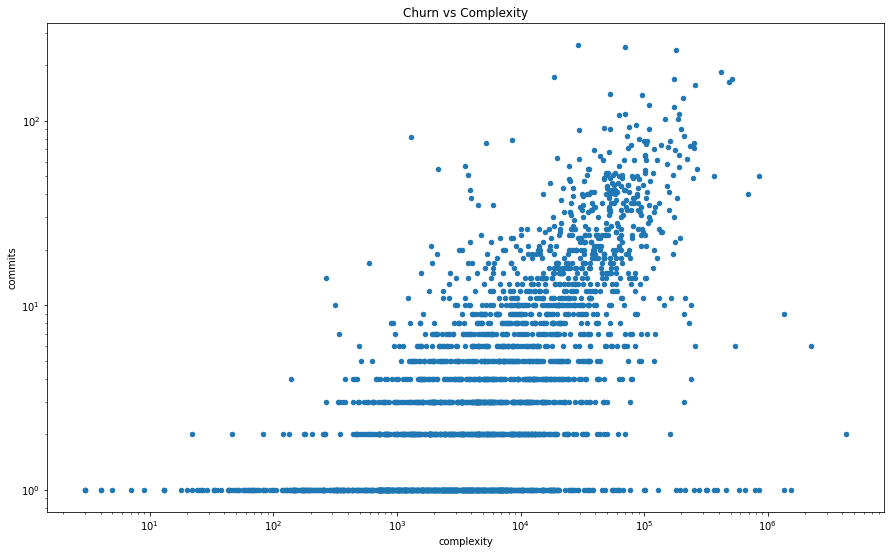

In [286]:
churn_complexity = pandas.merge(churn, complexity, on="filename", suffixes=("_ch", "_co"))
churn_complexity["churn_complexity"] = churn_complexity.apply(lambda row: row["commits"] * row["complexity"], axis=1)

churn_complexity.plot.scatter(x="complexity", y="commits", title="Churn vs Complexity", figsize=(15,9), logy=True, logx=True)

churn_complexity.sort_values("churn_complexity", ascending=False)[:top].style.hide_index()


# Top authors

The authors that contributed most to the repository.

In [287]:
top_authors = df.groupby(['author']).size().reset_index(name='commits').sort_values("commits", ascending=False)
top_authors[:top].style.hide_index()

author,commits
Victor Stinner,5415
Serhiy Storchaka,3494
Steve Dower,1021
Miss Islington (bot),1012
Pablo Galindo,754
Eric Snow,559
Yury Selivanov,465
Benjamin Peterson,399
Antoine Pitrou,394
Jeroen Demeyer,359


In [288]:
top_authors_per_package = df.groupby(['dirname', 'author']).size().reset_index(name='commits').sort_values("commits", ascending=False)
top_authors_per_package[:top].style.hide_index()

dirname,author,commits
Python,Victor Stinner,1022
Lib/test,Victor Stinner,861
Modules,Victor Stinner,693
Lib/test,Serhiy Storchaka,690
Objects,Victor Stinner,617
Modules,Serhiy Storchaka,452
Objects,Serhiy Storchaka,353
Include/internal,Victor Stinner,346
Python,Serhiy Storchaka,340
Include,Victor Stinner,319


# Change Coupling

Change coupling tells us which files have a tendency to change together.

In [289]:
group_size = 2

def size(iterable):
    return functools.reduce(lambda n, _: n + 1, iterable, 0)

commits = {name: len(commits) for name, commits in df.groupby(["filename"])}

all_file_pairs = sorted(pair for _, group in df.groupby(['commit']) for pair in itertools.combinations(group['filename'], group_size))
combos = {pair: size(pairs) for pair, pairs in itertools.groupby(all_file_pairs)}

change_coupling = sorted(((n / (n + sum(commits[a] for a in combo)), n, *combo) for combo, n in combos.items()), reverse=1)[:top*3]

def mkrow(coupling, filename, commits, first=False):
    return f"<tr><td>{first and coupling or ''}</td><td>{filename}</td><td>{commits}</td><td>{int(coupling / commits * 100)}</td></tr>"

rows = [
    [mkrow(coupling=n, filename=file_a, commits=commits[file_a], first=True), *(mkrow(coupling=n, filename=file_b, commits=commits[file_b]) for file_b in files)] for _, n, file_a, *files in change_coupling
]

HTML(f"<table><thead><tr><th>coupled entities</th><th>filenames</th><th>commits</th><th>% coupling</th></tr></thead><tbody>{''.join(''.join(row) for row in rows)}</tbody></table>")

coupled entities,filenames,commits,% coupling
16,Objects/clinic/bytearrayobject.c.h,16,100
,Objects/clinic/bytesobject.c.h,16,100
10,Modules/_blake2/blake2b_impl.c,10,100
,Modules/_blake2/blake2s_impl.c,10,100
8,Modules/clinic/sha256module.c.h,8,100
,Modules/clinic/sha512module.c.h,8,100
8,Modules/clinic/sha1module.c.h,8,100
,Modules/clinic/sha512module.c.h,8,100
8,Modules/clinic/sha1module.c.h,8,100
,Modules/clinic/sha256module.c.h,8,100
